# AI Saturdays Clustering Practice: AWS Sysadmin

Hay múltiples casos de uso en los que se pueden aplicar las diversas técnicas de clustering que hemos visto en la teoría. Y en esta Practice bastante breve nos vamos a centrar en el uso de **DBSCAN** (¡porque nos ha dado la gana!).

## Dataset

El ZIP que tienes en Eduflow (**_archive.zip_**) proviene del Numenta Anomaly Benchmark (NAB), y es un dataset utilizado para detectar anomalías en aplicaciones que funcionan en streaming u online.

Cuando lo descomprimas, verás que hay un montón de datasets con diferentes fines [(aquí te dejamos la documentación del dataset en Kaggle)](https://www.kaggle.com/boltzmannbrain/nab). El que a nosotros nos va a interesar es el relacionado con AWS Cloudwatch, que se encuentra en la carpeta **realAWSCloudwatch/realAWSCloudwatch**.

AWS Cloudwatch es la herramienta de Amazon para monitorizar los recursos y las aplicaciones de Amazon Web Services (AWS) que ejecuta en AWS en tiempo real. Por ello, se trata de una herramienta útil para la gente dedicada a la preparación y mantenimiento de sistemas informáticos, dado que aporta diversas métricas y maneras de visualizar picos de carga, monitorización de logs con herramientas como ElasticSearch, etc. [Pulsa aquí por si quieres aprender más sobre AWS Cloudwatch.](https://docs.aws.amazon.com/es_es/AmazonCloudWatch/latest/monitoring/WhatIsCloudWatch.html)

Para este ejercicio, vamos a ponernos en la piel de un _sysadmin_. El objetivo en nuestro caso será **detectar un cluster "base", que represente la funcionalidad "normal" de los sistemas que tenemos instalados en nuestro entorno informático, y posteriormente discriminar aquellos valores que muestren un funcionamiento anómalo.**

In [10]:
# Importar librerías necesarias
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import warnings
import itertools
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Entender los datos

Como hay muchos CSVs entre los cuales elegir, vamos a decantarnos por el CSV con nombre _ec2_cpu_utilization_825cc2.csv_. **(Una vez acabado el Practice, puedes probar si quieres con otros CSVs y explorar alternativas de desarrollo)**

Como bien dice el nombre del fichero, se habla del % de utilización de CPU de una instancia EC2, así que deberíamos tener 2 valores:

1. timestamp, que nos indique el momento del día en el que se ha tomado la medición.
2. value, que nos indique el % de uso de la CPU (Valor 0-100).

In [7]:
# Crear dataframe a partir de .csv
df = pd.read_csv('ec2_cpu_utilization_825cc2.csv')

# Mostrar número de filas y columnas del dataframe
print("Filas: " + str(df.shape[0]) + " Cols: " + str(df.shape[1]))

Filas: 4032 Cols: 2


In [8]:
# Comprobar la existencia de valores nulos en el dataset
df[df.isnull().any(axis=1)].count()

timestamp    0
value        0
dtype: int64

In [9]:
# Mostrar información general del dataframe
df.describe()

,value
count,4032.000000
mean,89.791262
std,12.078708
min,18.722500
25%,89.081000
50%,92.449000
75%,94.299500
max,99.118000


<AxesSubplot:>

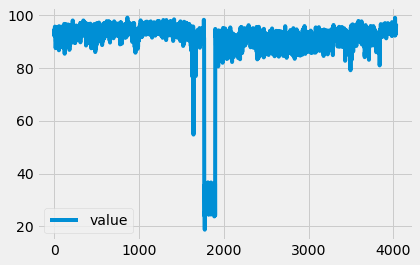

In [11]:
# Entender la pinta del dataframe con un plot sencillo
# df.plot('timestamp','value')
# Queda un eje X muy sucio. Pero se entendera que son fechas; lo que hacemos es un conteo y eso es lo que mostramos
df.plot()

¡Anda! Parece que vamos a tener bloques claros que marcar como cluster y como outlier...

### Escalar datos

A la hora de tratar datos puede sernos de interés hacer un escalado de los mismos para que su procesamiento posterior pueda ser más sencillo, además de para distinguir patrones de manera más clara (aunque aquí se vea alguno obvio a simple vista).

In [15]:
# Copiar datos de la columna "value" a una nueva lista
X = []
for i in range(0, len(df)-1):
    X.append([i,df["value"][i]])

# Escalar los datos con StandardScaler()
X = StandardScaler().fit_transform(X)

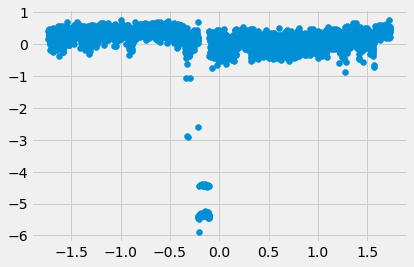

In [7]:
# Crear y visualizar scatterplot con los datos escalados
x = []
y = []
for i in range(0,len(X)):
    x.append(X[i][0])
    y.append(X[i][1])

plt.scatter(x,y)
plt.show()

### DBSCAN

Y aquí ya se ve de manera clara qué puntos debería detectar el algoritmo DBSCAN como _outliers_ o _valores atípicos_, y cuáles deberían estar dentro del cluster de actividad "normal". Así que vamos con ello.

In [8]:
# Ajustar el algoritmo DBSCAN
db = DBSCAN(eps=0.5, min_samples=200).fit(X)

# Obtener categorias diferenciadas de los puntos diferenciados por el DBSCAN
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

#Estimar numero de clusters (deberia ser 1, porque nuestro objetivo es tener un cluster de funcionamiento "principal")
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Numero estimado de clusters: %d' % n_clusters_)

Numero estimado de clusters: 1


Y ahora, vamos a pintar los clusters: con color azul para el cluster de funcionalidad "normal", y rojo para los _outliers_.

Numero estimado de clusters: 1


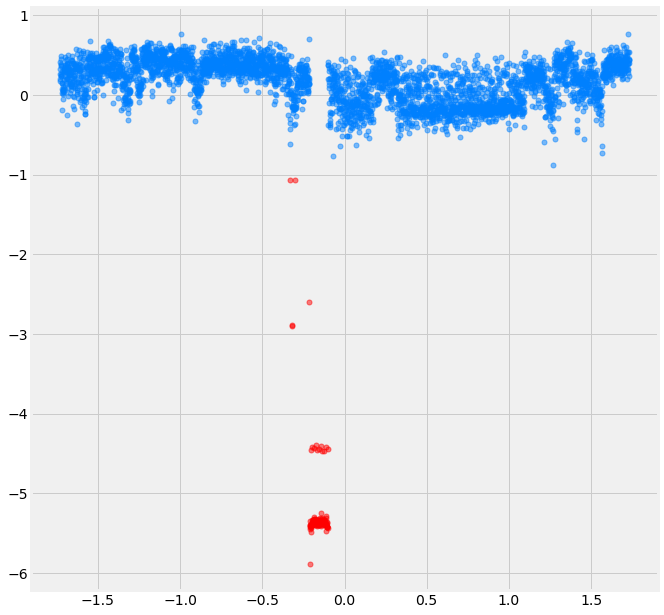

In [9]:
# Dividir las categorias y asignar un color a cada una
unique_labels = set(labels)
plt.figure(num=None, figsize=(10, 10), facecolor='w', edgecolor='k')
for k in unique_labels:
    col=[0,0.5,1,1]
    if k == -1:
        col = [1, 0, 0, 1] #Valores RGBA
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color=tuple(col),markersize=5, alpha=0.5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', color=tuple(col), markersize=5, alpha=0.5)

# Pintar el plot completo con nuevos colores    
print('Numero estimado de clusters: %d' % n_clusters_)
plt.show()

¡Y se acabó esta Practice! Como sysadmins, **¿qué hemos aprendido con esto?**

1. Que tenemos un funcionamiento "normal" esperable dentro de los datos de nuestra máquina EC2 de AWS (parece estar entre el 80-95% de uso de CPU, así que estamos amortizando correctamente el uso de nuestra instancia).
2. Pero que ha habido fallas en la instancia en un intervalo específico de tiempo (en este caso, se puede observar que sería como hacia la mitad de las fechas recogidas).

Esto nos puede llevar a diferentes **conclusiones** técnicas que pueden redundar en el funcionamiento del negocio, como por ejemplo:

- Investigar por qué se ha dado esa caída en el uso de la CPU de la instancia EC2, que casualmente correla con el momento en el que nos han escrito varios usuarios porque han dejado de recibir el servicio de la app super chuli que estamos vendiéndoles.
- Entender si ha sido realmente una falla del proveedor de la instancia (o sea, de AWS) o si, habiendo sido de nuestro equipo, hay que reforzar los medios de la gente de sistemas y/o DevOps para evitar que esto vuelva a suceder.